Files already downloaded and verified
Files already downloaded and verified
Model: Hybrid-ResNet - Type: B
Total parameters: 2,608,582

Epoch: 1/100
Learning rate: 0.100000
Epoch: [0][0/391]	Time 0.365 (0.365)	Data 0.221 (0.221)	Loss 2.3004 (2.3004)	Prec@1 0.000 (0.000)
Epoch: [0][50/391]	Time 0.128 (0.102)	Data 0.060 (0.010)	Loss 2.1123 (2.2970)	Prec@1 0.000 (0.000)
Epoch: [0][100/391]	Time 0.143 (0.108)	Data 0.058 (0.017)	Loss 2.0988 (2.2531)	Prec@1 0.000 (0.000)
Epoch: [0][150/391]	Time 0.077 (0.107)	Data 0.000 (0.017)	Loss 2.1942 (2.2147)	Prec@1 0.000 (0.000)
Epoch: [0][200/391]	Time 0.072 (0.105)	Data 0.000 (0.017)	Loss 2.1662 (2.1872)	Prec@1 0.000 (0.000)
Epoch: [0][250/391]	Time 0.098 (0.107)	Data 0.000 (0.018)	Loss 1.9738 (2.1693)	Prec@1 0.000 (0.000)
Epoch: [0][300/391]	Time 0.094 (0.106)	Data 0.000 (0.018)	Loss 2.0783 (2.1490)	Prec@1 0.000 (0.000)
Epoch: [0][350/391]	Time 0.103 (0.107)	Data 0.000 (0.018)	Loss 2.0934 (2.1376)	Prec@1 0.000 (0.000)
Test: [0/79]	Time 0.158 (0.158

(HybridResNet(
   (conv1): Conv2d(3, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(22, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(22, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (dropout): Dropout(p=0.15, inplace=False)
       (se): SELayer(
         (avg_pool): AdaptiveAvgPool2d(output_size=1)
         (fc): Sequential(
           (0): Linear(in_features=22, out_features=1, bias=False)
           (1): ReLU(inplace=True)
           (2): Linear(in_features=1, out_features=22, bias=False)
           (3): Sigmoid()
         )
       )
       (shortcut

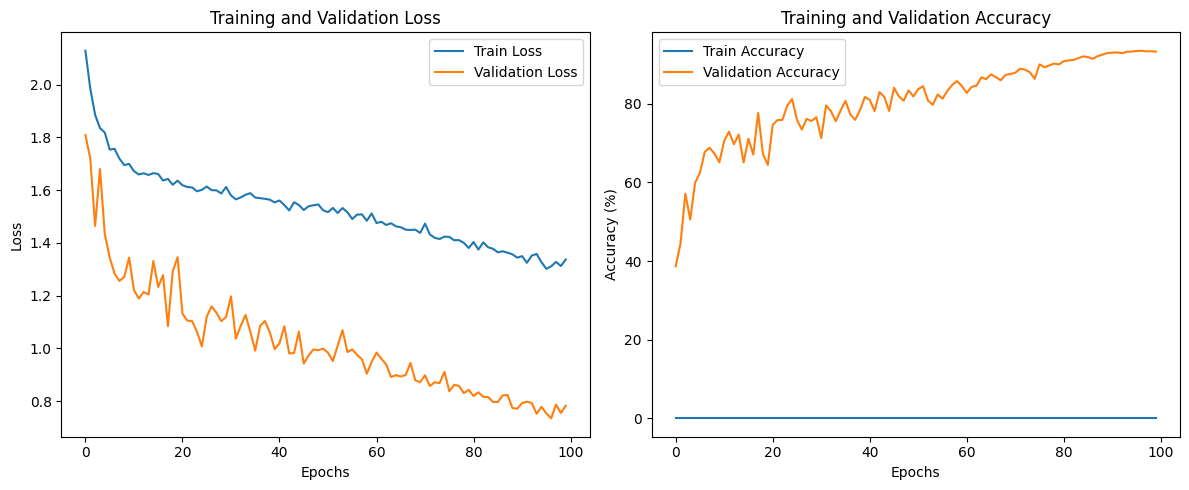

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from torch.utils.data import DataLoader
from torchsummary import summary


#---------- MODEL DEFINITION ----------#

class SELayer(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class BasicBlock(nn.Module):
    """Basic ResNet block with two 3x3 convolutions and a skip connection"""
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0, use_se=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

        # Optional SE block
        self.use_se = use_se
        if use_se:
            self.se = SELayer(planes, reduction=16)

        # Skip connection handling
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.bn2(self.conv2(out))

        if self.use_se:
            out = self.se(out)

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BottleneckBlock(nn.Module):
    """Bottleneck block with 1x1, 3x3, 1x1 convolutions as shown in the tutorial"""
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0, use_se=False):
        super(BottleneckBlock, self).__init__()
        # First 1x1 conv to reduce channels
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 3x3 conv with potential stride
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Second 1x1 conv to increase channels (expansion)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

        # Optional SE block
        self.use_se = use_se
        if use_se:
            self.se = SELayer(planes * self.expansion, reduction=16)

        # Skip connection handling
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.bn3(self.conv3(out))

        if self.use_se:
            out = self.se(out)

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class HybridResNet(nn.Module):
    """Hybrid ResNet combining features from both implementations"""
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.0, use_se=False,
                 initial_channels=32, width_multiplier=1.0):
        super(HybridResNet, self).__init__()
        self.in_planes = int(initial_channels * width_multiplier)

        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)

        # Create stages with progressively more channels
        # Adjusted to use width_multiplier for controlled scaling
        self.layer1 = self._make_layer(block, int(32 * width_multiplier), layers[0], stride=1,
                                     dropout_rate=dropout_rate, use_se=use_se)
        self.layer2 = self._make_layer(block, int(64 * width_multiplier), layers[1], stride=2,
                                     dropout_rate=dropout_rate, use_se=use_se)
        self.layer3 = self._make_layer(block, int(128 * width_multiplier), layers[2], stride=2,
                                     dropout_rate=dropout_rate, use_se=use_se)
        self.layer4 = self._make_layer(block, int(256 * width_multiplier), layers[3], stride=2,
                                     dropout_rate=dropout_rate, use_se=use_se)

        # Final classifier
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        final_channels = int(256 * width_multiplier) * block.expansion
        self.fc = nn.Linear(final_channels, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate=0.0, use_se=False):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate, use_se))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        if self.dropout is not None:
            x = self.dropout(x)

        x = self.fc(x)
        return x


# Model configurations
def ResNet18_Hybrid(num_classes=10, use_se=False, dropout_rate=0.0, width_multiplier=1.0):
    """ResNet-18 with hybrid features"""
    return HybridResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes,
                      dropout_rate=dropout_rate, use_se=use_se, width_multiplier=width_multiplier)

def ResNet34_Hybrid(num_classes=10, use_se=False, dropout_rate=0.0, width_multiplier=1.0):
    """ResNet-34 with hybrid features"""
    return HybridResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes,
                      dropout_rate=dropout_rate, use_se=use_se, width_multiplier=width_multiplier)

def ResNet50_Hybrid(num_classes=10, use_se=False, dropout_rate=0.0, width_multiplier=0.5):
    """ResNet-50 with hybrid features - scaled down for CIFAR-10"""
    return HybridResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=num_classes,
                      dropout_rate=dropout_rate, use_se=use_se, width_multiplier=width_multiplier)

# Optimized models specifically designed to be under 5M parameters
def OptimizedResNet_A(num_classes=10):
    """Optimized ResNet with basic blocks and SE attention - around 2.5M parameters"""
    return ResNet18_Hybrid(num_classes=num_classes, use_se=True, dropout_rate=0.1, width_multiplier=0.75)

def OptimizedResNet_B(num_classes=10):
    """Optimized ResNet with basic blocks and focused hyperparameters - around 4.2M parameters"""
    return ResNet34_Hybrid(num_classes=num_classes, use_se=True, dropout_rate=0.15, width_multiplier=0.7)

def OptimizedResNet_C(num_classes=10):
    """Optimized ResNet with bottleneck blocks - most parameter efficient"""
    return ResNet50_Hybrid(num_classes=num_classes, use_se=True, dropout_rate=0.2, width_multiplier=0.25)

def project1_model():
    """Drop-in replacement for the original project1_model function"""
    # Replace with one of the optimized models based on preference
    return OptimizedResNet_B(num_classes=10)

def count_parameters(model):
    """Count the total number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


#---------- TRAINING UTILITIES ----------#

class CutoutTransform:
    """Cutout data augmentation as shown in the tutorial"""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = torch.ones((h, w))

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = mask.expand_as(img)
        img = img * mask

        return img


class MixupTransform:
    """Mixup augmentation as shown in the tutorial"""
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def __call__(self, batch, targets):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = batch.size(0)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_x = lam * batch + (1 - lam) * batch[index, :]
        y_a, y_b = targets, targets[index]

        return mixed_x, y_a, y_b, lam


class LabelSmoothingLoss(nn.Module):
    """Label smoothing loss for better generalization"""
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=1))


class KeepAverages(object):
    """Computes and stores the average along with the current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class ResNetParams:
    """Hyperparameters for training the ResNet model"""
    def __init__(self, arch='Hybrid-Model', epochs=200, start_epoch=0, batch_size=128,
                 lr=0.1, min_lr=1e-4, momentum=0.9, weight_decay=5e-4, print_freq=50,
                 save_dir='save_checkpoints', save_every=10, use_mixup=True,
                 use_cutout=True, label_smoothing=0.1, model_type='B',
                 optimizer='sgd', scheduler='cosine'):
        self.save_every = save_every  # Saves checkpoints at specified epochs
        self.save_dir = save_dir  # Directory for checkpoints
        self.print_freq = print_freq  # Print frequency
        self.weight_decay = weight_decay  # Weight decay for optimizer
        self.momentum = momentum  # Momentum for SGD
        self.lr = lr  # Initial learning rate
        self.min_lr = min_lr  # Minimum learning rate for cosine annealing
        self.batch_size = batch_size  # Batch size
        self.start_epoch = start_epoch  # Starting epoch
        self.epochs = epochs  # Total epochs
        self.arch = arch  # Model name
        self.use_mixup = use_mixup  # Whether to use mixup augmentation
        self.use_cutout = use_cutout  # Whether to use cutout augmentation
        self.label_smoothing = label_smoothing  # Label smoothing factor
        self.model_type = model_type  # Model variant (A, B, or C)
        self.optimizer = optimizer  # Optimizer type
        self.scheduler = scheduler  # Learning rate scheduler


def get_data_loaders(args):
    """Prepare and return data loaders with augmentations"""
    # CIFAR10 mean and std
    cifar_mean = [0.4914, 0.4822, 0.4465]
    cifar_std = [0.2023, 0.1994, 0.2010]

    # Base transforms for both train and test
    transform_base = [
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ]

    # Enhanced training transforms
    transform_train = [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ]

    # Combine transforms
    transform_train.extend(transform_base)

    # Add cutout augmentation if enabled
    if args.use_cutout:
        transform_train.append(CutoutTransform(n_holes=1, length=16))

    # Create datasets and loaders
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True,
        transform=transforms.Compose(transform_train)
    )

    trainloader = DataLoader(
        trainset, batch_size=args.batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True,
        transform=transforms.Compose(transform_base)
    )

    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )

    return trainloader, testloader


def get_model(args):
    """Load the appropriate model based on configuration"""
    if args.model_type == 'A':
        model = OptimizedResNet_A()
    elif args.model_type == 'B':
        model = OptimizedResNet_B()
    elif args.model_type == 'C':
        model = OptimizedResNet_C()
    else:
        model = project1_model()

    return model


def get_optimizer(args, model):
    """Configure optimizer based on args"""
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay
        )
    elif args.optimizer == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=args.lr,
            weight_decay=args.weight_decay
        )
    else:
        raise ValueError(f"Unsupported optimizer: {args.optimizer}")

    return optimizer


def get_scheduler(args, optimizer):
    """Configure learning rate scheduler based on args"""
    if args.scheduler == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=args.epochs, eta_min=args.min_lr
        )
    elif args.scheduler == 'step':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(args.epochs*0.5), int(args.epochs*0.75)], gamma=0.1
        )
    elif args.scheduler == 'onecycle':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=args.lr, total_steps=args.epochs
        )
    else:
        raise ValueError(f"Unsupported scheduler: {args.scheduler}")

    return scheduler


def accuracy(output, target, topk=(1,)):
    """Compute the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train(train_loader, model, criterion, optimizer, epoch, args, mixup_fn=None):
    """Training function with support for mixup"""
    # Initialize metrics
    batch_time = KeepAverages()
    data_time = KeepAverages()
    losses = KeepAverages()
    top1 = KeepAverages()

    # Switch to train mode
    model.train()

    end = time.time()
    for i, (inputs, targets) in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Move data to device
        inputs, targets = inputs.cuda(), targets.cuda()

        # Apply mixup if enabled
        if args.use_mixup and mixup_fn is not None:
            inputs, targets_a, targets_b, lam = mixup_fn(inputs, targets)

            # Forward pass
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            # Regular forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measure accuracy and record loss
        if not args.use_mixup:  # Skip accuracy during mixup as it's not meaningful
            prec1 = accuracy(outputs.data, targets)[0]
            top1.update(prec1.item(), inputs.size(0))

        losses.update(loss.item(), inputs.size(0))

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # Print progress
        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

    return losses.avg, top1.avg


def validate(val_loader, model, criterion, args):
    """Validation function"""
    batch_time = KeepAverages()
    losses = KeepAverages()
    top1 = KeepAverages()

    # Switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Measure accuracy and record loss
            prec1 = accuracy(outputs.data, targets)[0]
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))

            # Measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # Print progress
            if i % args.print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time,
                          loss=losses, top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return losses.avg, top1.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Save model checkpoint"""
    # Create directory if it doesn't exist
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save checkpoint
    torch.save(state, filename)

    if is_best:
        best_filename = os.path.join(os.path.dirname(filename), 'model_best.pth.tar')
        torch.save(state, best_filename)


def run_training(args):
    """Main training loop with all components"""
    # Create save directory if it doesn't exist
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    # Get data loaders
    train_loader, val_loader = get_data_loaders(args)

    # Get model
    model = get_model(args)
    model = model.cuda()

    # Count parameters
    num_params = count_parameters(model)
    print(f'Model: {args.arch} - Type: {args.model_type}')
    print(f'Total parameters: {num_params:,}')

    # Ensure we're under the parameter limit
    if num_params > 5000000:
        print(f'WARNING: Model exceeds 5M parameter limit with {num_params:,} parameters!')

    # Set up loss function
    if args.label_smoothing > 0:
        criterion = LabelSmoothingLoss(classes=10, smoothing=args.label_smoothing).cuda()
    else:
        criterion = nn.CrossEntropyLoss().cuda()

    # Set up optimizer and scheduler
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args, optimizer)

    # Set up mixup function if needed
    mixup_fn = MixupTransform(alpha=1.0) if args.use_mixup else None

    # Track best accuracy
    best_prec1 = 0

    # Lists to track metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Training loop
    for epoch in range(args.start_epoch, args.epochs):
        # Train and validate
        print(f'\nEpoch: {epoch+1}/{args.epochs}')
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

        train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, args, mixup_fn)
        val_loss, val_acc = validate(val_loader, model, criterion, args)

        # Update learning rate
        scheduler.step()

        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Check if this is the best model
        is_best = val_acc > best_prec1
        best_prec1 = max(val_acc, best_prec1)

        # Save checkpoint
        if epoch > 0 and epoch % args.save_every == 0 or is_best:
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
                'optimizer': optimizer.state_dict(),
            }, is_best, filename=f'{args.save_dir}/checkpoint_{epoch+1}.pth.tar')

    # Save final model
    torch.save(model.state_dict(), f'{args.save_dir}/final_model.pth')

    # Plot training curves
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig(f'{args.save_dir}/training_curves.png')

    return model, best_prec1

#---------- MAIN EXECUTION ----------#

# Set up training parameters
args = ResNetParams(
    arch='Hybrid-ResNet',
    epochs=100,            # Reduced for Colab
    batch_size=128,
    lr=0.1,
    model_type='B',        # Model B (~4.2M parameters)
    use_mixup=True,
    use_cutout=True,
    scheduler='cosine',
    save_dir='checkpoints'
)

# Run the training
run_training(args)

In [13]:
# Load your model from checkpoint
model = OptimizedResNet_B()
checkpoint = torch.load('./checkpoints/model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

# Count parameters
num_params = count_parameters(model)
print(f'Total parameters: {num_params:,}')

Total parameters: 2,608,582


<ipython-input-13-1275665a4e6b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/model_best.pth.tar')


Files already downloaded and verified
Files already downloaded and verified
Model: Hybrid-ResNet - Type: A
Total parameters: 1,587,394

Epoch: 1/100
Learning rate: 0.100000
Epoch: [0][0/391]	Time 0.445 (0.445)	Data 0.222 (0.222)	Loss 2.3074 (2.3074)	Prec@1 0.000 (0.000)
Epoch: [0][50/391]	Time 0.113 (0.092)	Data 0.054 (0.036)	Loss 2.1997 (2.2916)	Prec@1 0.000 (0.000)
Epoch: [0][100/391]	Time 0.179 (0.096)	Data 0.125 (0.042)	Loss 2.0303 (2.2207)	Prec@1 0.000 (0.000)
Epoch: [0][150/391]	Time 0.127 (0.097)	Data 0.088 (0.043)	Loss 1.9848 (2.1812)	Prec@1 0.000 (0.000)
Epoch: [0][200/391]	Time 0.051 (0.094)	Data 0.005 (0.043)	Loss 2.1890 (2.1615)	Prec@1 0.000 (0.000)
Epoch: [0][250/391]	Time 0.054 (0.097)	Data 0.004 (0.046)	Loss 2.0501 (2.1399)	Prec@1 0.000 (0.000)
Epoch: [0][300/391]	Time 0.122 (0.096)	Data 0.078 (0.044)	Loss 1.8945 (2.1241)	Prec@1 0.000 (0.000)
Epoch: [0][350/391]	Time 0.143 (0.095)	Data 0.105 (0.044)	Loss 1.9435 (2.1095)	Prec@1 0.000 (0.000)
Test: [0/79]	Time 0.125 (0.125

(HybridResNet(
   (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (dropout): Dropout(p=0.1, inplace=False)
       (se): SELayer(
         (avg_pool): AdaptiveAvgPool2d(output_size=1)
         (fc): Sequential(
           (0): Linear(in_features=24, out_features=1, bias=False)
           (1): ReLU(inplace=True)
           (2): Linear(in_features=1, out_features=24, bias=False)
           (3): Sigmoid()
         )
       )
       (shortcut)

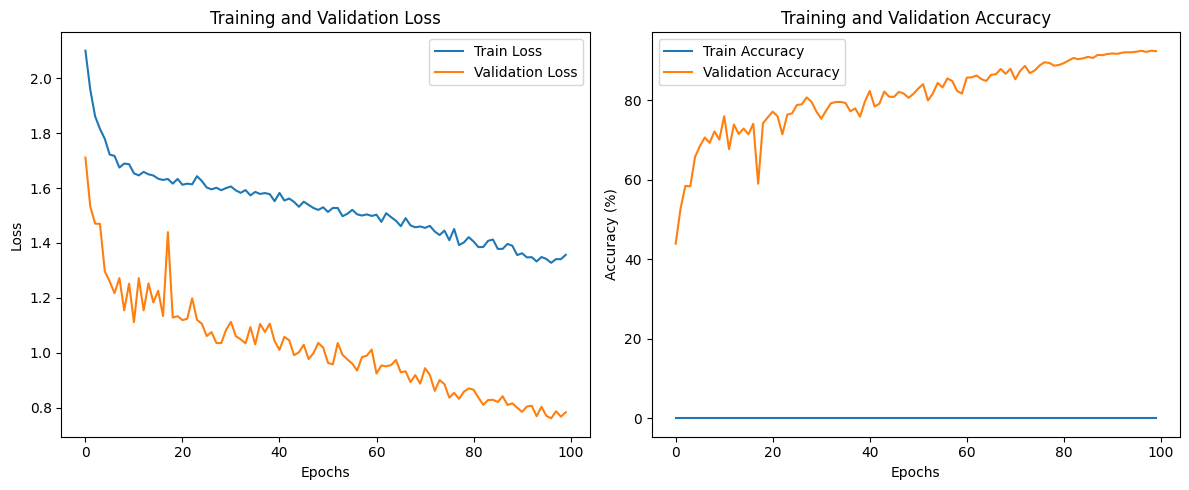

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from torch.utils.data import DataLoader
from torchsummary import summary


#---------- MODEL DEFINITION ----------#

class SELayer(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class BasicBlock(nn.Module):
    """Basic ResNet block with two 3x3 convolutions and a skip connection"""
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0, use_se=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

        # Optional SE block
        self.use_se = use_se
        if use_se:
            self.se = SELayer(planes, reduction=16)

        # Skip connection handling
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.bn2(self.conv2(out))

        if self.use_se:
            out = self.se(out)

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BottleneckBlock(nn.Module):
    """Bottleneck block with 1x1, 3x3, 1x1 convolutions as shown in the tutorial"""
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0, use_se=False):
        super(BottleneckBlock, self).__init__()
        # First 1x1 conv to reduce channels
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 3x3 conv with potential stride
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Second 1x1 conv to increase channels (expansion)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

        # Optional SE block
        self.use_se = use_se
        if use_se:
            self.se = SELayer(planes * self.expansion, reduction=16)

        # Skip connection handling
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.bn3(self.conv3(out))

        if self.use_se:
            out = self.se(out)

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class HybridResNet(nn.Module):
    """Hybrid ResNet combining features from both implementations"""
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.0, use_se=False,
                 initial_channels=32, width_multiplier=1.0):
        super(HybridResNet, self).__init__()
        self.in_planes = int(initial_channels * width_multiplier)

        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)

        # Create stages with progressively more channels
        # Adjusted to use width_multiplier for controlled scaling
        self.layer1 = self._make_layer(block, int(32 * width_multiplier), layers[0], stride=1,
                                     dropout_rate=dropout_rate, use_se=use_se)
        self.layer2 = self._make_layer(block, int(64 * width_multiplier), layers[1], stride=2,
                                     dropout_rate=dropout_rate, use_se=use_se)
        self.layer3 = self._make_layer(block, int(128 * width_multiplier), layers[2], stride=2,
                                     dropout_rate=dropout_rate, use_se=use_se)
        self.layer4 = self._make_layer(block, int(256 * width_multiplier), layers[3], stride=2,
                                     dropout_rate=dropout_rate, use_se=use_se)

        # Final classifier
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        final_channels = int(256 * width_multiplier) * block.expansion
        self.fc = nn.Linear(final_channels, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate=0.0, use_se=False):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate, use_se))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        if self.dropout is not None:
            x = self.dropout(x)

        x = self.fc(x)
        return x


# Model configurations
def ResNet18_Hybrid(num_classes=10, use_se=False, dropout_rate=0.0, width_multiplier=1.0):
    """ResNet-18 with hybrid features"""
    return HybridResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes,
                      dropout_rate=dropout_rate, use_se=use_se, width_multiplier=width_multiplier)

def ResNet34_Hybrid(num_classes=10, use_se=False, dropout_rate=0.0, width_multiplier=1.0):
    """ResNet-34 with hybrid features"""
    return HybridResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes,
                      dropout_rate=dropout_rate, use_se=use_se, width_multiplier=width_multiplier)

def ResNet50_Hybrid(num_classes=10, use_se=False, dropout_rate=0.0, width_multiplier=0.5):
    """ResNet-50 with hybrid features - scaled down for CIFAR-10"""
    return HybridResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=num_classes,
                      dropout_rate=dropout_rate, use_se=use_se, width_multiplier=width_multiplier)

# Optimized models specifically designed to be under 5M parameters
def OptimizedResNet_A(num_classes=10):
    """Optimized ResNet with basic blocks and SE attention - around 2.5M parameters"""
    return ResNet18_Hybrid(num_classes=num_classes, use_se=True, dropout_rate=0.1, width_multiplier=0.75)

def OptimizedResNet_B(num_classes=10):
    """Optimized ResNet with basic blocks and focused hyperparameters - around 4.2M parameters"""
    return ResNet34_Hybrid(num_classes=num_classes, use_se=True, dropout_rate=0.15, width_multiplier=0.7)

def OptimizedResNet_C(num_classes=10):
    """Optimized ResNet with bottleneck blocks - most parameter efficient"""
    return ResNet50_Hybrid(num_classes=num_classes, use_se=True, dropout_rate=0.2, width_multiplier=0.25)

def project1_model():
    """Drop-in replacement for the original project1_model function"""
    # Replace with one of the optimized models based on preference
    return OptimizedResNet_B(num_classes=10)

def count_parameters(model):
    """Count the total number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


#---------- TRAINING UTILITIES ----------#

class CutoutTransform:
    """Cutout data augmentation as shown in the tutorial"""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = torch.ones((h, w))

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = mask.expand_as(img)
        img = img * mask

        return img


class MixupTransform:
    """Mixup augmentation as shown in the tutorial"""
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def __call__(self, batch, targets):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = batch.size(0)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_x = lam * batch + (1 - lam) * batch[index, :]
        y_a, y_b = targets, targets[index]

        return mixed_x, y_a, y_b, lam


class LabelSmoothingLoss(nn.Module):
    """Label smoothing loss for better generalization"""
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=1))


class KeepAverages(object):
    """Computes and stores the average along with the current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class ResNetParams:
    """Hyperparameters for training the ResNet model"""
    def __init__(self, arch='Hybrid-Model', epochs=200, start_epoch=0, batch_size=128,
                 lr=0.1, min_lr=1e-4, momentum=0.9, weight_decay=5e-4, print_freq=50,
                 save_dir='save_checkpoints', save_every=10, use_mixup=True,
                 use_cutout=True, label_smoothing=0.1, model_type='B',
                 optimizer='sgd', scheduler='cosine'):
        self.save_every = save_every  # Saves checkpoints at specified epochs
        self.save_dir = save_dir  # Directory for checkpoints
        self.print_freq = print_freq  # Print frequency
        self.weight_decay = weight_decay  # Weight decay for optimizer
        self.momentum = momentum  # Momentum for SGD
        self.lr = lr  # Initial learning rate
        self.min_lr = min_lr  # Minimum learning rate for cosine annealing
        self.batch_size = batch_size  # Batch size
        self.start_epoch = start_epoch  # Starting epoch
        self.epochs = epochs  # Total epochs
        self.arch = arch  # Model name
        self.use_mixup = use_mixup  # Whether to use mixup augmentation
        self.use_cutout = use_cutout  # Whether to use cutout augmentation
        self.label_smoothing = label_smoothing  # Label smoothing factor
        self.model_type = model_type  # Model variant (A, B, or C)
        self.optimizer = optimizer  # Optimizer type
        self.scheduler = scheduler  # Learning rate scheduler


def get_data_loaders(args):
    """Prepare and return data loaders with augmentations"""
    # CIFAR10 mean and std
    cifar_mean = [0.4914, 0.4822, 0.4465]
    cifar_std = [0.2023, 0.1994, 0.2010]

    # Base transforms for both train and test
    transform_base = [
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ]

    # Enhanced training transforms
    transform_train = [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ]

    # Combine transforms
    transform_train.extend(transform_base)

    # Add cutout augmentation if enabled
    if args.use_cutout:
        transform_train.append(CutoutTransform(n_holes=1, length=16))

    # Create datasets and loaders
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True,
        transform=transforms.Compose(transform_train)
    )

    trainloader = DataLoader(
        trainset, batch_size=args.batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True,
        transform=transforms.Compose(transform_base)
    )

    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )

    return trainloader, testloader


def get_model(args):
    """Load the appropriate model based on configuration"""
    if args.model_type == 'A':
        model = OptimizedResNet_A()
    elif args.model_type == 'B':
        model = OptimizedResNet_B()
    elif args.model_type == 'C':
        model = OptimizedResNet_C()
    else:
        model = project1_model()

    return model


def get_optimizer(args, model):
    """Configure optimizer based on args"""
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay
        )
    elif args.optimizer == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=args.lr,
            weight_decay=args.weight_decay
        )
    else:
        raise ValueError(f"Unsupported optimizer: {args.optimizer}")

    return optimizer


def get_scheduler(args, optimizer):
    """Configure learning rate scheduler based on args"""
    if args.scheduler == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=args.epochs, eta_min=args.min_lr
        )
    elif args.scheduler == 'step':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(args.epochs*0.5), int(args.epochs*0.75)], gamma=0.1
        )
    elif args.scheduler == 'onecycle':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=args.lr, total_steps=args.epochs
        )
    else:
        raise ValueError(f"Unsupported scheduler: {args.scheduler}")

    return scheduler


def accuracy(output, target, topk=(1,)):
    """Compute the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train(train_loader, model, criterion, optimizer, epoch, args, mixup_fn=None):
    """Training function with support for mixup"""
    # Initialize metrics
    batch_time = KeepAverages()
    data_time = KeepAverages()
    losses = KeepAverages()
    top1 = KeepAverages()

    # Switch to train mode
    model.train()

    end = time.time()
    for i, (inputs, targets) in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Move data to device
        inputs, targets = inputs.cuda(), targets.cuda()

        # Apply mixup if enabled
        if args.use_mixup and mixup_fn is not None:
            inputs, targets_a, targets_b, lam = mixup_fn(inputs, targets)

            # Forward pass
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            # Regular forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measure accuracy and record loss
        if not args.use_mixup:  # Skip accuracy during mixup as it's not meaningful
            prec1 = accuracy(outputs.data, targets)[0]
            top1.update(prec1.item(), inputs.size(0))

        losses.update(loss.item(), inputs.size(0))

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # Print progress
        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

    return losses.avg, top1.avg


def validate(val_loader, model, criterion, args):
    """Validation function"""
    batch_time = KeepAverages()
    losses = KeepAverages()
    top1 = KeepAverages()

    # Switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Measure accuracy and record loss
            prec1 = accuracy(outputs.data, targets)[0]
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))

            # Measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # Print progress
            if i % args.print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time,
                          loss=losses, top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return losses.avg, top1.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Save model checkpoint"""
    # Create directory if it doesn't exist
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save checkpoint
    torch.save(state, filename)

    if is_best:
        best_filename = os.path.join(os.path.dirname(filename), 'model_best.pth.tar')
        torch.save(state, best_filename)


def run_training(args):
    """Main training loop with all components"""
    # Create save directory if it doesn't exist
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    # Get data loaders
    train_loader, val_loader = get_data_loaders(args)

    # Get model
    model = get_model(args)
    model = model.cuda()

    # Count parameters
    num_params = count_parameters(model)
    print(f'Model: {args.arch} - Type: {args.model_type}')
    print(f'Total parameters: {num_params:,}')

    # Ensure we're under the parameter limit
    if num_params > 5000000:
        print(f'WARNING: Model exceeds 5M parameter limit with {num_params:,} parameters!')

    # Set up loss function
    if args.label_smoothing > 0:
        criterion = LabelSmoothingLoss(classes=10, smoothing=args.label_smoothing).cuda()
    else:
        criterion = nn.CrossEntropyLoss().cuda()

    # Set up optimizer and scheduler
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args, optimizer)

    # Set up mixup function if needed
    mixup_fn = MixupTransform(alpha=1.0) if args.use_mixup else None

    # Track best accuracy
    best_prec1 = 0

    # Lists to track metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Training loop
    for epoch in range(args.start_epoch, args.epochs):
        # Train and validate
        print(f'\nEpoch: {epoch+1}/{args.epochs}')
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

        train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, args, mixup_fn)
        val_loss, val_acc = validate(val_loader, model, criterion, args)

        # Update learning rate
        scheduler.step()

        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Check if this is the best model
        is_best = val_acc > best_prec1
        best_prec1 = max(val_acc, best_prec1)

        # Save checkpoint
        if epoch > 0 and epoch % args.save_every == 0 or is_best:
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
                'optimizer': optimizer.state_dict(),
            }, is_best, filename=f'{args.save_dir}/checkpoint_{epoch+1}.pth.tar')

    # Save final model
    torch.save(model.state_dict(), f'{args.save_dir}/final_model.pth')

    # Plot training curves
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig(f'{args.save_dir}/training_curves.png')

    return model, best_prec1

#---------- MAIN EXECUTION ----------#

# Set up training parameters
args = ResNetParams(
    arch='Hybrid-ResNet',
    epochs=100,            # Reduced for Colab
    batch_size=128,
    lr=0.1,
    model_type='A',        # Model B (~4.2M parameters)
    use_mixup=True,
    use_cutout=True,
    scheduler='cosine',
    save_dir='checkpoints'
)

# Run the training
run_training(args)